# Installing Modules

In [1]:
%%capture
!pip install -qq pytorch_lightning tableprint spacy==3
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

# Imports

In [2]:
# Import Libraries
import numpy as np
import math
import matplotlib.pyplot  as plt
import spacy
import pandas as pd
import os

# PyTorch related
import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# My Custom Code
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import tableprint as tp

In [3]:
# Manual Seed
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Language Definitions

In [5]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

# Tokenizers

In [6]:
token_transform[SRC_LANGUAGE]  = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# Yield Function

In [7]:
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Special Tokens

In [8]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Building Vocab

In [9]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 1.62MB/s]


## Setting default token

In [10]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
print(f"Length of Source Vocabulary: {len(vocab_transform['de'])}")
print(f"Length of Targe Vocabulary: {len(vocab_transform['en'])}")

Length of Source Vocabulary: 19215
Length of Targe Vocabulary: 10838


# Collator

In [12]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

# DataLoader

In [13]:
BATCH_SIZE = 32
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 275kB/s]
mmt16_task1_test.tar.gz: 100%|██████████| 43.9k/43.9k [00:00<00:00, 263kB/s]


# Model

## Boilerplate Code

In [14]:
class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        src, tgt = batch 
        tgt_input =  tgt[:-1, :]
                                                                             
        output = self(src,tgt_input )

        output = output.reshape(-1, output.shape[2])
        tgt = tgt[1:].reshape(-1)

        loss_train = self.loss(output, tgt)

        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src, tgt = batch 
        tgt_input =  tgt[:-1, :]
                                                                             
        output = self(src,tgt_input )

        output = output.reshape(-1, output.shape[2])
        tgt = tgt[1:].reshape(-1)

        loss_valid = self.loss(output, tgt)
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.sanity_checking:
          return
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
          self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss'])
          self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
          self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

## Transformer Class/Model

In [15]:
class Seq2SeqTransformer(TL):
    def __init__(
                    self,
                    embedding_size,
                    src_vocab_size,
                    trg_vocab_size,
                    src_pad_idx,
                    num_heads,
                    num_encoder_layers,
                    num_decoder_layers,
                    forward_expansion,
                    dropout,
                    max_len,
                    device,
                ):
        super(Seq2SeqTransformer, self).__init__()

        self.loss = nn.CrossEntropyLoss(ignore_index=src_pad_idx)
        self.lr = 1e-4

        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.transformer = nn.Transformer(
                                        embedding_size,
                                        num_heads,
                                        num_encoder_layers,
                                        num_decoder_layers,
                                        forward_expansion,
                                        dropout,
                                    )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

In [16]:
src_pad_idx = 1
trg_pad_idx = 1

src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
trg_vocab_size = len(vocab_transform[TGT_LANGUAGE])
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len = 100
forward_expansion = 4

model = Seq2SeqTransformer(
                embedding_size,
                src_vocab_size,
                trg_vocab_size,
                src_pad_idx,
                num_heads,
                num_encoder_layers,
                num_decoder_layers,
                forward_expansion,
                dropout,
                max_len,
                device
            )

# Training

In [17]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [18]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2_Assign_12', version=0)
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type             | Params
------------------------------------------------------------
0 | loss                   | CrossEntropyLoss | 0     
1 | src_word_embedding     | Embedding        | 9.8 M 
2 | src_position_embedding | Embedding        | 51.2 K
3 | trg_word_embedding     | Embedding        | 5.5 M 
4 | trg_position_embedding | Embedding        | 51.2 K
5 | transformer            | Transformer      | 9.5 M 
6 | fc_out                 | Linear           | 5.6 M 
7 | dropout                | Dropout          | 0     
------------------------------------------------------------
30.6 M    Trainable params
0         Non-trainable params
30.6 M    Total params
122.201   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │           1 │           0 │      59.294 │      4.0825 │


│           2 │      76.467 │      4.3369 │      59.935 │      4.0933 │


│           3 │      65.952 │      4.1889 │      77.599 │      4.3516 │


│           4 │      68.152 │      4.2217 │      86.732 │      4.4628 │


│           5 │      100.12 │      4.6064 │      77.201 │      4.3464 │


│           6 │      85.256 │      4.4457 │      71.276 │      4.2666 │


│           7 │      65.703 │      4.1852 │      74.376 │      4.3091 │


│           8 │      63.668 │      4.1537 │      72.017 │      4.2769 │


│           9 │      54.674 │      4.0014 │      72.971 │      4.2901 │


│          10 │      58.779 │      4.0738 │      81.607 │      4.4019 │


│          11 │      62.824 │      4.1403 │      77.059 │      4.3446 │


│          12 │      52.783 │      3.9662 │      69.161 │      4.2364 │


│          13 │      50.612 │      3.9242 │      72.959 │      4.2899 │


│          14 │       55.22 │      4.0113 │      72.401 │      4.2822 │


│          15 │      55.772 │      4.0213 │       70.25 │      4.2521 │


│          16 │      54.734 │      4.0025 │      70.439 │      4.2548 │


│          17 │      44.203 │      3.7888 │      73.917 │      4.3029 │


│          18 │      47.588 │      3.8626 │      68.369 │      4.2249 │


│          19 │      50.641 │      3.9248 │      70.408 │      4.2543 │


│          20 │      39.421 │      3.6743 │      61.346 │      4.1165 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

# Training Log

In [19]:
root='./csv_logs/' + 'END2_Assign_12' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

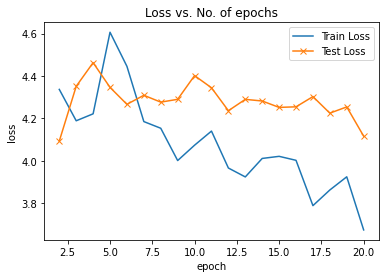

In [20]:
plt.plot(metrics['epoch'][1:], metrics['Train Loss'][1:], label="Train Loss")
plt.plot(metrics['epoch'][1:], metrics['Valid Loss'][1:], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

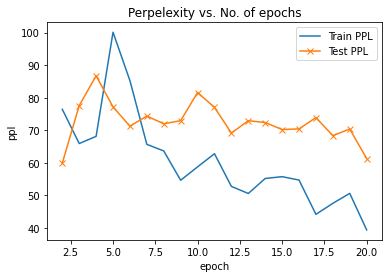

In [21]:
plt.plot(metrics['epoch'][1:], metrics['Train PPL'][1:], label="Train PPL")
plt.plot(metrics['epoch'][1:], metrics['Valid PPL'][1:], '-x', label="Test PPL")
plt.xlabel('epoch')
plt.ylabel('ppl')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');

# Inference on Random Samples from Test Data

In [22]:
%%capture
model.to(device)
model.eval()

In [23]:
for i in np.random.randint(0,32, 5):
  src_sent_i = next(iter(test_loader))[0][:, i]
  trg_sent_i = next(iter(test_loader))[1][:, i]
  stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
  stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
  src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[:stop_ind_src]]
  trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[:stop_ind_trg]]
  src_sent = " ".join(src_sent_tok[1:]) # skip the initial <bos> token
  trg_sent = " ".join(trg_sent_tok[1:]) # skip the initial <bos> token
  src_sent_tensor = src_sent_i.clone().detach().unsqueeze(1).to(device)   
  trg_sent_tensor = trg_sent_i.clone().detach().unsqueeze(1).to(device) 
  with torch.no_grad():
        output = model(src_sent_tensor, trg_sent_tensor)
        out = output.squeeze(1)
        out = torch.argmax(out,dim=1)
        if any(out==3) == False: # if <eos> token is not found
            stop_ind_pred = len(out)   # use complete sentence
        else:
            stop_ind_pred = (out==3).nonzero()[0].item() # stop when <eos> token is found
        pred_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in out]
        pred_sent = " ".join(pred_sent_tok[:stop_ind_pred])
        start = "\033[1m"
        end = "\033[0;0m"
        print(f'{start}Source Sentence: {end}{src_sent}')
        print(f'{start}Target Sentence: {end}{trg_sent}')
        print(f'{start}Translated Sentence: {end}{pred_sent}')
        print()

Source Sentence: Ein Mädchen in einem Jeanskleid läuft über einen erhöhten Schwebebalken .
Target Sentence: A girl in a jean dress is walking along a raised balance beam .
Translated Sentence: A young in a blue shirt is playing on a pool . . .

Source Sentence: Zwei Männer tun so als seien sie Statuen , während Frauen ihnen zusehen .
Target Sentence: Two men pretend to be <unk> while women look on .
Translated Sentence: Two men are one a are a a in . a

Source Sentence: Eine Gruppe von Menschen steht vor einem Iglu .
Target Sentence: A group of people standing in front of an igloo .
Translated Sentence: A group of people are on a of a a .

Source Sentence: Eine Teenagerin spielt bei einem Spiel Trompete auf dem Feld .
Target Sentence: A teenager plays her trumpet on the field at a game .
Translated Sentence: A young is a a to a beach . a . .

Source Sentence: Eine Frau , die in einer Küche eine Schale mit Essen hält .
Target Sentence: A woman holding a bowl of food in a kitchen .
Trans